In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD, IncrementalPCA
from scipy.sparse import csr_matrix, lil_matrix
import scipy
from itertools import chain
import statistics
from sklearn.pipeline import make_pipeline
from sklearn import svm, preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from numpy import expand_dims
from tensorflow.keras.utils import to_categorical
from tensorflow import concat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow
import os
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg19 import preprocess_input
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
from tensorflow import tile
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
image_size = 224
input_shape = (image_size, image_size, 3)
os.chdir('/home/jupyter-bbeltzun')

In [3]:
covered = 'full'

In [4]:
# importation des données

drawings_names = os.listdir(covered + '/' + covered + '_all/')
seasons = ['Autumn','Winter','Spring','Summer']
i = 0
drawings = []
labels = list()

for img in tqdm(drawings_names):
    if not img.startswith('.'):
        for season in seasons:
            if season in img:
                labels.append(str(season))
        img = load_img('img/'+img, target_size=(224,224,3))
        img = img_to_array(img)
        img = expand_dims(img,axis=0)
        img = preprocess_input(img)
        img = np.array(img)
        drawings.append(img)
        i = i + 1

100%|██████████| 641/641 [00:55<00:00, 11.63it/s]


In [6]:
# importer VGG19 et avoir en sortie les activations aux couches de convolution
vgg = tensorflow.keras.applications.VGG19(weights='imagenet', include_top=True, input_shape = (224,224,3))
ixs = []

i=0
for layer in vgg.layers:
    if "conv" in layer.name:
        ixs.append(i)
    i=i+1

outputs = [vgg.layers[i].output for i in ixs]
feature_extraction_model = Model(inputs=vgg.input, outputs=outputs)

kernels_size = []
for i in range(len(feature_extraction_model.outputs)):
    kernels_size.append((feature_extraction_model.outputs[i].shape[1],feature_extraction_model.outputs[i].shape[2]))

# nombre de channels par couche
nb_channels = []
for i in range(len(feature_extraction_model.outputs)):
    nb_channels.append(feature_extraction_model.outputs[i].shape[3])

In [8]:
for i in range(len(ixs)):
    print('Indice ' + str(i) + ' : La longueur d\'un vecteur de la couche ' + str(ixs[i]) + ' pour une image donnée est de : ' + str(kernels_size[i][0]**2 * nb_channels[i]) +
          ' (taille kernel : ' + str(kernels_size[i][0]) + 'x' + str(kernels_size[i][0]) + ' et nombre channels : ' + str(nb_channels[i]) + ')')

Indice 0 : La longueur d'un vecteur de la couche 1 pour une image donnée est de : 3211264 (taille kernel : 224x224 et nombre channels : 64)
Indice 1 : La longueur d'un vecteur de la couche 2 pour une image donnée est de : 3211264 (taille kernel : 224x224 et nombre channels : 64)
Indice 2 : La longueur d'un vecteur de la couche 4 pour une image donnée est de : 1605632 (taille kernel : 112x112 et nombre channels : 128)
Indice 3 : La longueur d'un vecteur de la couche 5 pour une image donnée est de : 1605632 (taille kernel : 112x112 et nombre channels : 128)
Indice 4 : La longueur d'un vecteur de la couche 7 pour une image donnée est de : 802816 (taille kernel : 56x56 et nombre channels : 256)
Indice 5 : La longueur d'un vecteur de la couche 8 pour une image donnée est de : 802816 (taille kernel : 56x56 et nombre channels : 256)
Indice 6 : La longueur d'un vecteur de la couche 9 pour une image donnée est de : 802816 (taille kernel : 56x56 et nombre channels : 256)
Indice 7 : La longueur d

## A faire tourner pour chaque couche (pas besoin de sampler 50% sur les couches 0 et 1 ici)

In [15]:
depth = 0 # correspond à l'indice au-dessus
outputs = vgg.layers[ixs[depth]].output
feature_extraction_model = Model(inputs=vgg.input, outputs=outputs)
nb_channel = feature_extraction_model.outputs[0].shape[3]
kernel_size = feature_extraction_model.outputs[0].shape[1]

In [16]:
features_row = np.zeros((len(drawings),kernel_size**2 * nb_channel), dtype = 'float16')

for i in tqdm(range(len(drawings))): # pour chaque image, on extrait les features
    tmp_drawing = drawings[i]
    tmp_feature = feature_extraction_model.predict(tmp_drawing)
    flattened_features = []
    for j in range(nb_channel): # aplatissement de chaque feature qui devient une ligne de la matrice pour cette couche
        flattened_features.append(tmp_feature[0,:,:,j].flatten())
    flattened_features = list(chain.from_iterable(flattened_features))
    features_row[i,:] = flattened_features

100%|██████████| 640/640 [07:22<00:00,  1.45it/s]


### PCA

In [17]:
scaler = StandardScaler()
standardized_features_row = scaler.fit_transform(features_row)
pca = PCA(n_components = 0.8)
X_pca = pca.fit_transform(standardized_features_row)
X_pca.shape

np.savez_compressed('features_' + covered + '/PCA_table/features_PCA_' + covered + '_' + str(depth) + '.npz', X_pca, delimiters=',')
# data = np.load to load
# data['arr_0'] to have the dataset

#### Plot explained variance + cumulative explained variance

In [ ]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('features_' + covered + '/plot_variance/cumulative_' + covered + '_' + str(depth))
plt.show()

In [ ]:
plt.step(range(0,len(exp_var_pca)), exp_var_pca, where='mid',label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('features_' + covered + '/plot_variance/variance_' + covered + '_' + str(depth))
plt.show()

In [ ]:
clf = SVC()
scores = cross_val_score(clf, X_pca, labels, cv=10)

In [ ]:
np.savetxt('features_' + covered + '/scores/score_' + covered + '_' + str(depth) + '.csv', scores, delimiter=",")

## Feature activation of the 2 FC layers

In [15]:
depth = 24 # FC layers : depth 23 and 24
outputs = vgg.layers[depth].output
feature_extraction_model = Model(inputs=vgg.input, outputs=outputs)
length_fc = feature_extraction_model.outputs[0].shape[1]

In [16]:
features_row = np.zeros((len(drawings),length_fc), dtype = 'float32')

for i in tqdm(range(len(drawings))): # pour chaque image, on extrait les features
    tmp_drawing = drawings[i]
    tmp_feature = feature_extraction_model.predict(tmp_drawing)
    features_row[i,:] = tmp_feature

100%|██████████| 640/640 [03:23<00:00,  3.14it/s]


In [17]:
scaler = StandardScaler()
standardized_features_row = scaler.fit_transform(features_row)
pca = PCA(n_components = 0.8)
X_pca = pca.fit_transform(standardized_features_row)
X_pca.shape

np.savez_compressed('features_' + covered + '/PCA_table/features_PCA_' + covered + '_' + vgg.layers[depth].name + '.npz', X_pca, delimiters=',')

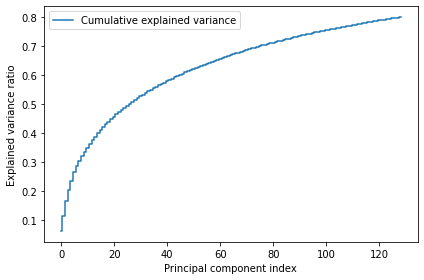

In [19]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('features_' + covered + '/plot_variance/cumulative_' + covered + '_' +  vgg.layers[depth].name)
plt.show()

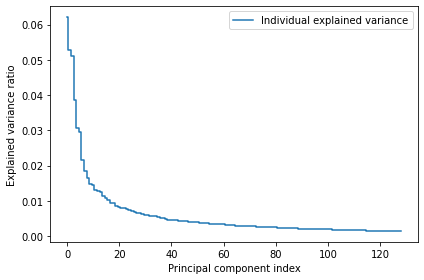

In [20]:
plt.step(range(0,len(exp_var_pca)), exp_var_pca, where='mid',label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('features_' + covered + '/plot_variance/variance_' + covered + '_' + vgg.layers[depth].name)
plt.show()

In [21]:
clf = SVC()
scores = cross_val_score(clf, X_pca, labels, cv=10)

np.savetxt('features_' + covered + '/scores/score_' + covered + '_' + vgg.layers[depth].name + '.csv', scores, delimiter=",")

## Zip les dossiers pour les télécharger

In [29]:
!tar -czf features_empty.tar.gz features_empty
!tar -czf features_full.tar.gz features_full